In [16]:
!pip install meteostat
# Import Meteostat library
from meteostat import Stations

# Get nearby weather stations
stations = Stations()
stations = stations.nearby(49.2497, -123.1193)
station = stations.fetch(1)


# Print DataFrame
print(station)

                       name country region    wmo  icao  latitude  longitude  \
id                                                                             
71201  Vancouver Harbour CS      CA     BC  71201  CWHC      49.3    -123.12   

       elevation           timezone hourly_start hourly_end daily_start  \
id                                                                        
71201        2.0  America/Vancouver   1980-03-01 2025-04-24  1925-11-01   

       daily_end monthly_start monthly_end     distance  
id                                                       
71201 2024-04-28    1925-01-01  2022-01-01  5593.335349  


In [2]:
dar_pos=(-6.79,39.21)
dar_stations = stations.nearby(*dar_pos)
dar_station = dar_stations.fetch(1) 

# Print DataFrame
print(dar_station)

                        name country region    wmo  icao  latitude  longitude  \
id                                                                              
63894  Dar Es Salaam Airport      TZ     DS  63894  HTDA   -6.8667       39.2   

       elevation              timezone hourly_start hourly_end daily_start  \
id                                                                           
63894       55.0  Africa/Dar_es_Salaam   1950-02-01 2025-06-27  1957-01-01   

       daily_end monthly_start monthly_end     distance  
id                                                       
63894 2025-06-24    1949-01-01  2021-01-01  8599.816185  


In [5]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly

# Set time period
start = datetime(2025, 6, 1)
end = datetime(2025, 7, 27, 23, 59)

# Get hourly data
data = Hourly('63894', start, end)#, model=False)
data = data.fetch()

# Print DataFrame
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2025-06-01 00:00:00,24.0,22.1,89.0,0.1,NaN,220.0,7.0,NaN,1018.0,NaN,2.0
2025-06-01 01:00:00,24.0,22.1,89.0,0.0,NaN,170.0,11.0,NaN,1018.0,NaN,2.0
2025-06-01 02:00:00,23.3,21.7,91.0,0.0,NaN,203.0,11.1,NaN,1018.2,NaN,2.0
2025-06-01 03:00:00,23.3,21.7,91.0,0.0,NaN,199.0,11.1,NaN,1018.3,NaN,2.0
2025-06-01 04:00:00,23.0,21.1,89.0,0.0,NaN,240.0,9.0,NaN,1018.0,NaN,2.0


In [6]:
data.tail()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2025-07-10 05:00:00,23.5,20.4,83.0,NaN,NaN,209.0,14.8,NaN,1019.5,NaN,2.0
2025-07-10 06:00:00,24.4,20.7,80.0,NaN,NaN,206.0,14.8,NaN,1019.7,NaN,2.0
2025-07-10 07:00:00,25.8,20.4,72.0,NaN,NaN,194.0,18.5,NaN,1019.5,NaN,2.0
2025-07-10 08:00:00,27.1,20.0,65.0,NaN,NaN,183.0,20.4,NaN,1019.2,NaN,3.0
2025-07-10 09:00:00,28.4,19.6,59.0,NaN,NaN,174.0,22.2,NaN,1019.0,NaN,3.0


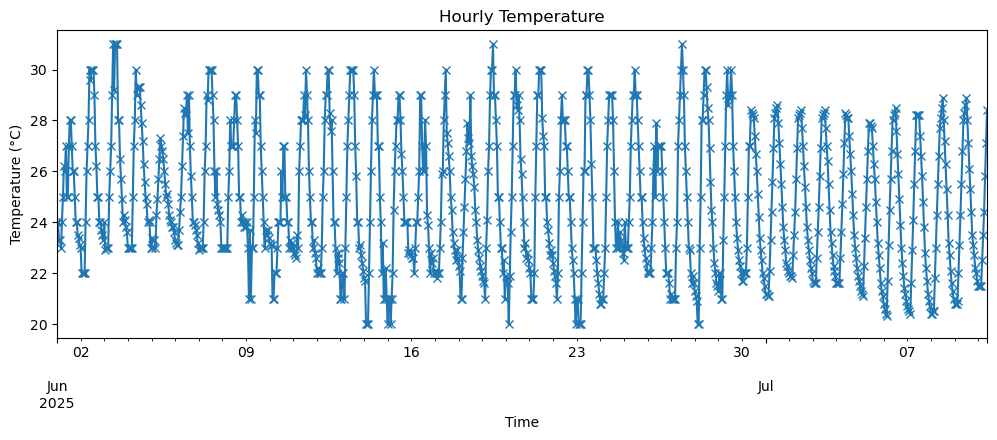

In [7]:
import matplotlib.pyplot as plt

data['temp'].plot(figsize=(12, 4), title='Hourly Temperature', style='-' \
'x')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

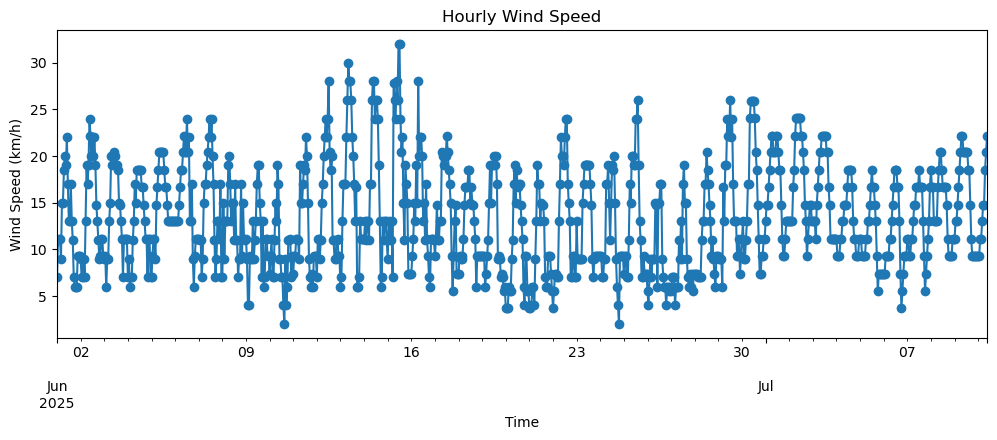

time
2025-06-01 00:00:00     7.0
2025-06-01 01:00:00    11.0
2025-06-01 02:00:00    11.1
2025-06-01 03:00:00    11.1
2025-06-01 04:00:00     9.0
                       ... 
2025-07-10 05:00:00    14.8
2025-07-10 06:00:00    14.8
2025-07-10 07:00:00    18.5
2025-07-10 08:00:00    20.4
2025-07-10 09:00:00    22.2
Name: wspd, Length: 946, dtype: float64

In [8]:
data['wspd'].plot(figsize=(12, 4), title='Hourly Wind Speed',style="-o")
plt.xlabel('Time')
plt.ylabel('Wind Speed (km/h)')
plt.show()
data['wspd']

# Uganda


In [10]:
mak_pos=(0.355,32.583)
mak_stations = stations.nearby(*mak_pos)
mak_station = mak_stations.fetch()
mak_station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
63680,Kampala,UG,KM,63680,<NA>,0.3167,32.6167,1144.0,Africa/Kampala,1973-01-02,2025-04-12,NaT,NaT,NaT,NaT,5.672621e+03
63705,Entebbe Airport,UG,WA,63705,HUEN,0.0500,32.4500,1155.0,Africa/Kampala,1949-01-21,2025-06-28,1957-01-02,2022-04-25,1949-01-01,2002-01-01,3.699864e+04
63682,Jinja,UG,JI,63682,HUJI,0.4500,33.1833,1175.0,Africa/Kampala,1957-01-01,2025-06-27,1955-01-01,1986-12-30,1955-01-01,1986-01-01,6.757937e+04
63654,Masindi,UG,MZ,63654,HUMI,1.6833,31.7167,1146.0,Africa/Kampala,1963-03-16,2025-06-27,1926-01-01,1984-12-31,1926-01-01,1984-01-01,1.763267e+05
63684,Tororo,UG,TR,63684,HUTO,0.6833,34.1667,1170.0,Africa/Kampala,1957-01-01,2025-05-14,1929-01-01,1986-12-31,1929-01-01,1986-01-01,1.798361e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91800,Penrhyn Island / Omoka,KW,<NA>,91800,NCPY,-9.0167,-158.0667,2.0,Asia/Kuwait,2020-01-14,2025-06-28,2020-01-15,2022-04-25,NaT,NaT,1.849264e+07
91802,Penrhyn Aws,CK,<NA>,91802,<NA>,-9.0333,-158.0500,1.0,Pacific/Rarotonga,NaT,NaT,NaT,NaT,2020-01-01,2021-01-01,1.849291e+07
91487,Fanning Island,NZ,<NA>,91487,PLFA,3.8500,-159.3667,5.0,Pacific/Kiritimati,1943-04-21,2015-06-21,1943-10-24,1945-06-26,1943-01-01,1945-01-01,1.860734e+07


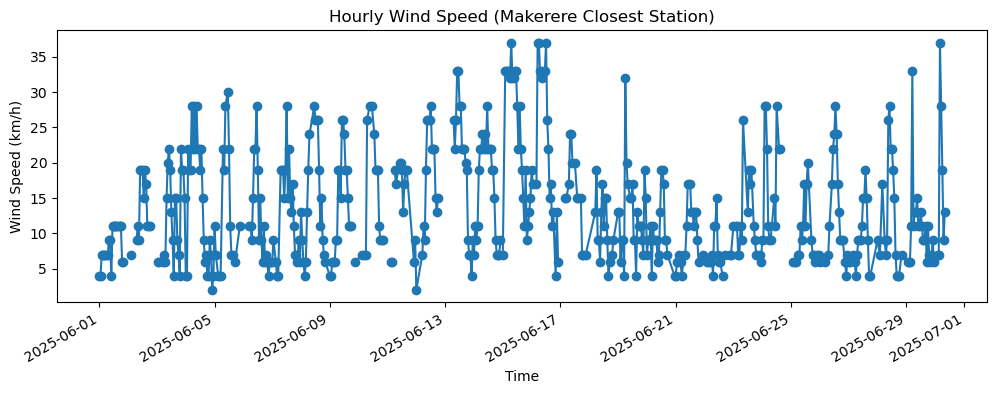

In [13]:
from meteostat import Hourly
from datetime import datetime

# Get the WMO ID of the closest station to Makerere University
mak_closest_wmo = mak_station.index[1]

# Set a time period (use the same as before for consistency)

mak_start = datetime(2025, 6, 1)
mak_end = datetime(2025, 7, 27, 23, 59)


    
mak_data = Hourly(mak_closest_wmo, mak_start, mak_end, model=False).fetch()


# Plot wind speed if data is available
if not mak_data.empty and 'wspd' in mak_data.columns:
    mak_data['wspd'].plot(figsize=(12, 4), title='Hourly Wind Speed (Makerere Closest Station)',style='-o')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed (km/h)')
    plt.show()
else:
    print("No wind speed data available for the selected station and period.")


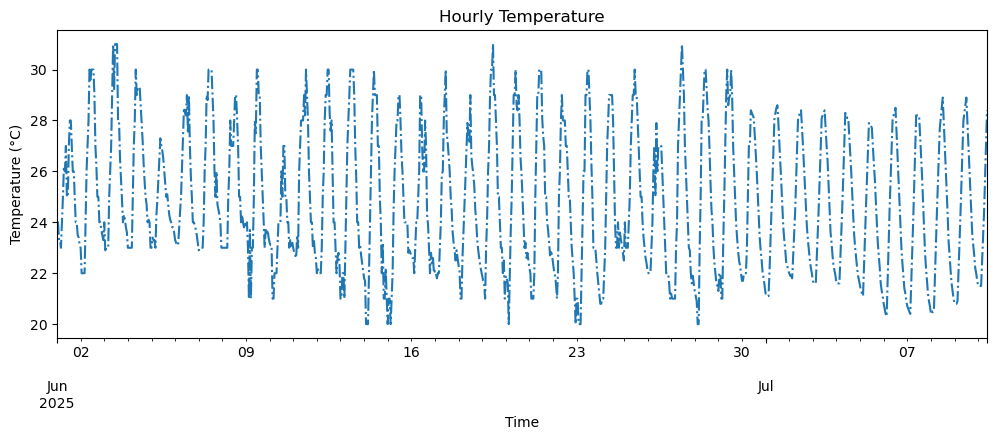

In [15]:
data['temp'].plot(figsize=(12, 4), title='Hourly Temperature', style='-.')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()